In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras import regularizers,optimizers
from skopt import BayesSearchCV
from load_data import split_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import choice, randrange


In [2]:
data=pd.read_csv("../input/data_prepared.csv")

data["pixels"]=data["pixels"].apply(lambda x:np.asarray(x.split()).astype(float).reshape(-1,1).ravel())
data["pixels"]=data["pixels"].apply(lambda x: (x/255).reshape((48,48,1)))
X=data["pixels"]
y=data.drop(columns=["pixels"])

X_train,X_test,y_train,y_test=split_data(X,y)

### Basic model

In [3]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(48, 48 ,1), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

### Compile model

In [12]:


epochs = 25
lrate = 0.01
decay = lrate/epochs
adam = optimizers.Adam(decay=decay)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,verbose=1, batch_size=50)

model.save("../models/model_basic_as_cp.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 128)      

### Same model with more convolution layers 

With our first model we have reached an accuracy of 0.63. We are traying to improve it by adding one more bunch of convolution layers to our model.

In [11]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(48, 48 ,1), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(16384, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.save("../models/model_3convl1024__not_trained.h5")

In [ ]:
epochs = 50
lrate = 0.01
decay = lrate/epochs
adam = optimizers.Adam(decay=decay)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,verbose=1, batch_size=50)

model.save("../models/model_3coonl1024.h5")

With this model trained with we have reached  an accuracy of 0.65.  We are trying to improve it with some data augmentation techniques

### Data augmentation techniques 

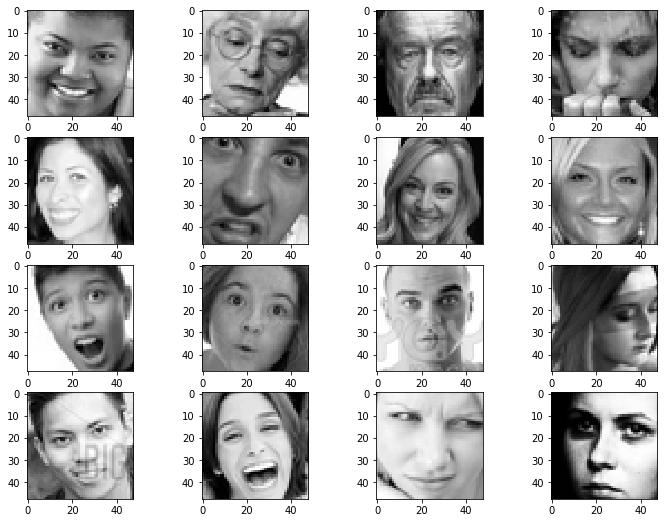

In [39]:
fig, axis=plt.subplots(4,4,figsize=(12,9))

for i in range(4):
    for j in range(4):
        axis[i][j].imshow(np.reshape(choice(X)*255,(48,48)),cmap="gray")

There are 5 main techniques for image data augmentation: 

* Image shifts 
* Image flips 
* Image rotations 
* Image brightness
* Image zoom 

Since most of the images are well centered and cropped, it doesn't make sense using shifts or zoom, so we are going to keep it to horizontal flips, rotations between -25º and +25º and brightness.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator=ImageDataGenerator(rotation_range=25)

In [7]:
model_data_augmentation=load_model("../models/model_3coonl1024.h5",compile=True)

data_generator.fit(X_train)

epochs = 15
lrate = 0.01
decay = lrate/epochs

adam = optimizers.Adam( decay=decay)
model_data_augmentation.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

print(model_data_augmentation.summary())

model_data_augmentation.fit(data_generator.flow(X_train, y_train, batch_size=50),validation_data=(X_test, y_test),steps_per_epoch=500, epochs=epochs)

model_data_augmentation.save("../models/model_basic_with_data_augmentation_rotatation_25degrees.h5")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_17 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 24, 24, 128)      

We have improved the validation accuracy from 0.65 to 0.75 by random rotation generation. Now we are going to apply horizontal flipping to images.

In [8]:
data_generator=ImageDataGenerator(horizontal_flip=True)

model_data_augmentation=load_model("../models/model_basic_with_data_augmentation_rotatation_25degrees.h5",compile=True)

data_generator.fit(X_train)

epochs = 15
lrate = 0.01
decay = lrate/epochs

adam = optimizers.Adam( decay=decay)
model_data_augmentation.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

print(model_data_augmentation.summary())

model_data_augmentation.fit(data_generator.flow(X_train, y_train, batch_size=50),validation_data=(X_test, y_test),steps_per_epoch=500, epochs=epochs)

model_data_augmentation.save("model_basic_with_data_augmentation_rotatation_horizontal_flip")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_17 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 24, 24, 128)      

We haven't improved the accuracyof the model with this extra training. Now we are going to try data augmentation with random brightness range.

In [9]:
data_generator=ImageDataGenerator(brightness_range=[0.2,1.0])

model_data_augmentation=load_model("../models/model_basic_with_data_augmentation_rotation&horizontal_flip.h5",compile=True)

data_generator.fit(X_train)

epochs = 15
lrate = 0.01
decay = lrate/epochs

adam = optimizers.Adam( decay=decay)
model_data_augmentation.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

print(model_data_augmentation.summary())

model_data_augmentation.fit(data_generator.flow(X_train, y_train, batch_size=50),validation_data=(X_test, y_test),steps_per_epoch=500, epochs=epochs)

model_data_augmentation.save("../models/model_basic_with_data_augmentation_rotation&horizontal_flip&brightness.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

This technique doesn't improve the performance of the model. We have reached an accuracy 0.75 with pur best model.